# Library

In [1]:
# -*- coding: utf-8 -*-
"""ML_supurvised_prediksi_harga_rumah_final.ipynb

Automatically generated by Colab.

Original file is located at
    [Link ke Colab Anda jika ada, atau hapus baris ini]
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.stats import pointbiserialr, pearsonr # Tidak digunakan secara aktif di output akhir, tapi ada di kode asli

# --- Konfigurasi Tampilan Pandas dan Plot ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-whitegrid') # Menggunakan style plot yang tersedia

Penjelasan:

Baris komentar awal biasanya berisi informasi tentang file dan encoding.
import ...: Bagian ini mengimpor semua pustaka (library) yang dibutuhkan untuk analisis data, manipulasi data, visualisasi, pemodelan, dan evaluasi.
pandas (sebagai pd): Untuk bekerja dengan struktur data tabular (DataFrame).
numpy (sebagai np): Untuk operasi numerik, terutama array.
matplotlib.pyplot (sebagai plt) dan seaborn (sebagai sns): Untuk membuat visualisasi data (grafik, plot).
XGBRegressor: Model machine learning XGBoost untuk tugas regresi.
train_test_split: Untuk membagi dataset menjadi data latih dan data uji.
GridSearchCV: Untuk melakukan pencarian hiperparameter terbaik secara otomatis.
StandardScaler: Untuk melakukan penskalaan fitur.
mean_squared_error, mean_absolute_error, r2_score: Metrik untuk mengevaluasi performa model regresi.
pd.set_option(...): Mengatur opsi tampilan Pandas agar semua kolom ditampilkan dan lebar output disesuaikan.
plt.style.use(...): Mengatur gaya default untuk plot Matplotlib agar terlihat lebih menarik.

1. Import Data

In [2]:
# Ganti dengan path file Anda jika berbeda
file_path = '/content/DATA RUMAH.xlsx'

try:
    df_raw = pd.read_excel(file_path)
    print("Data berhasil dimuat.")
except FileNotFoundError:
    print(f"File '{file_path}' tidak ditemukan. Harap unggah file atau perbaiki path.")
    print("Menggunakan data dummy untuk melanjutkan...")
    # Data dummy jika file tidak ditemukan (untuk demonstrasi)
    data_dummy = {
        'no': range(1, 51), # Menambah jumlah data dummy
        'nama': [f'Rumah Mewah Tipe {chr(65+(i%7))}{i%3+1}' for i in range(50)],
        'harga': np.random.randint(250000000, 3000000000, 50),
        'luas_tanah': np.random.randint(50, 250, 50),
        'luas_bangunan': np.random.randint(35, 200, 50),
        'kamar_tidur': np.random.randint(1, 6, 50),
        'kamar_mandi': np.random.randint(1, 5, 50),
        'garasi': np.random.randint(0, 4, 50) # Memperluas rentang garasi
    }
    df_raw = pd.DataFrame(data_dummy)

print("\nData Awal (5 baris pertama):")
print(df_raw.head())
print(f"\nInformasi Data Awal:")
df_raw.info()
print(f"\nBentuk DataFrame Awal: {df_raw.shape}")

Data berhasil dimuat.

Data Awal (5 baris pertama):
   NO                                         NAMA RUMAH       HARGA   LB   LT  KT  KM  GRS
0   1  Rumah Murah Hook Tebet Timur, Tebet, Jakarta S...  3800000000  220  220   3   3    0
1   2  Rumah Modern di Tebet dekat Stasiun, Tebet, Ja...  4600000000  180  137   4   3    2
2   3  Rumah Mewah 2 Lantai Hanya 3 Menit Ke Tebet, T...  3000000000  267  250   4   4    4
3   4           Rumah Baru Tebet, Tebet, Jakarta Selatan   430000000   40   25   2   2    0
4   5  Rumah Bagus Tebet komp Gudang Peluru lt 350m, ...  9000000000  400  355   6   5    3

Informasi Data Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   NO          1010 non-null   int64 
 1   NAMA RUMAH  1010 non-null   object
 2   HARGA       1010 non-null   int64 
 3   LB          1010 non-null   int64 
 4   LT          1010 non-nu

2. Pra-pemrosesan dan Pembersihan Data

In [3]:
# Membuat salinan untuk pra-pemrosesan
df = df_raw.copy()

# Mengubah nama kolom agar lebih konsisten
df.columns = ['no', 'nama_properti','harga_rp', 'luas_tanah_m2', 'luas_bangunan_m2', 'kamar_tidur', 'kamar_mandi', 'garasi_mobil']
print("\nData setelah rename kolom (5 baris pertama):")
print(df.head())

# Menghapus kolom 'no' (identifier, tidak relevan untuk model)
if 'no' in df.columns:
    df = df.drop('no', axis=1)

# Menghapus kolom 'nama_properti' (membutuhkan NLP lebih lanjut jika ingin diekstrak, untuk saat ini dihapus)
if 'nama_properti' in df.columns:
    df = df.drop('nama_properti', axis=1)

print("\nData setelah menghapus kolom 'no' dan 'nama_properti' (5 baris pertama):")
print(df.head())

# Penanganan Missing Value
print("\nJumlah Missing Value per Kolom Sebelum Penanganan:")
print(df.isna().sum())

# Contoh strategi imputasi (ganti atau sesuaikan jika perlu)
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median()) # Imputasi dengan median untuk numerik

print("\nJumlah Missing Value per Kolom Setelah Penanganan (Median Imputation):")
print(df.isna().sum())


Data setelah rename kolom (5 baris pertama):
   no                                      nama_properti    harga_rp  luas_tanah_m2  luas_bangunan_m2  kamar_tidur  kamar_mandi  garasi_mobil
0   1  Rumah Murah Hook Tebet Timur, Tebet, Jakarta S...  3800000000            220               220            3            3             0
1   2  Rumah Modern di Tebet dekat Stasiun, Tebet, Ja...  4600000000            180               137            4            3             2
2   3  Rumah Mewah 2 Lantai Hanya 3 Menit Ke Tebet, T...  3000000000            267               250            4            4             4
3   4           Rumah Baru Tebet, Tebet, Jakarta Selatan   430000000             40                25            2            2             0
4   5  Rumah Bagus Tebet komp Gudang Peluru lt 350m, ...  9000000000            400               355            6            5             3

Data setelah menghapus kolom 'no' dan 'nama_properti' (5 baris pertama):
     harga_rp  luas_tanah_m2

3. Eksplorasi Data dan Visualisasi (EDA)


Statistik Deskriptif Data Bersih:
           harga_rp  luas_tanah_m2  luas_bangunan_m2  kamar_tidur  kamar_mandi  garasi_mobil
count  1.010000e+03    1010.000000       1010.000000  1010.000000  1010.000000   1010.000000
mean   7.628987e+09     276.539604        237.432673     4.668317     3.607921      1.920792
std    7.340946e+09     177.864557        179.957604     1.572776     1.420066      1.510998
min    4.300000e+08      40.000000         25.000000     2.000000     1.000000      0.000000
25%    3.262500e+09     150.000000        130.000000     4.000000     3.000000      1.000000
50%    5.000000e+09     216.500000        165.000000     4.000000     3.000000      2.000000
75%    9.000000e+09     350.000000        290.000000     5.000000     4.000000      2.000000
max    6.500000e+10    1126.000000       1400.000000    10.000000    10.000000     10.000000


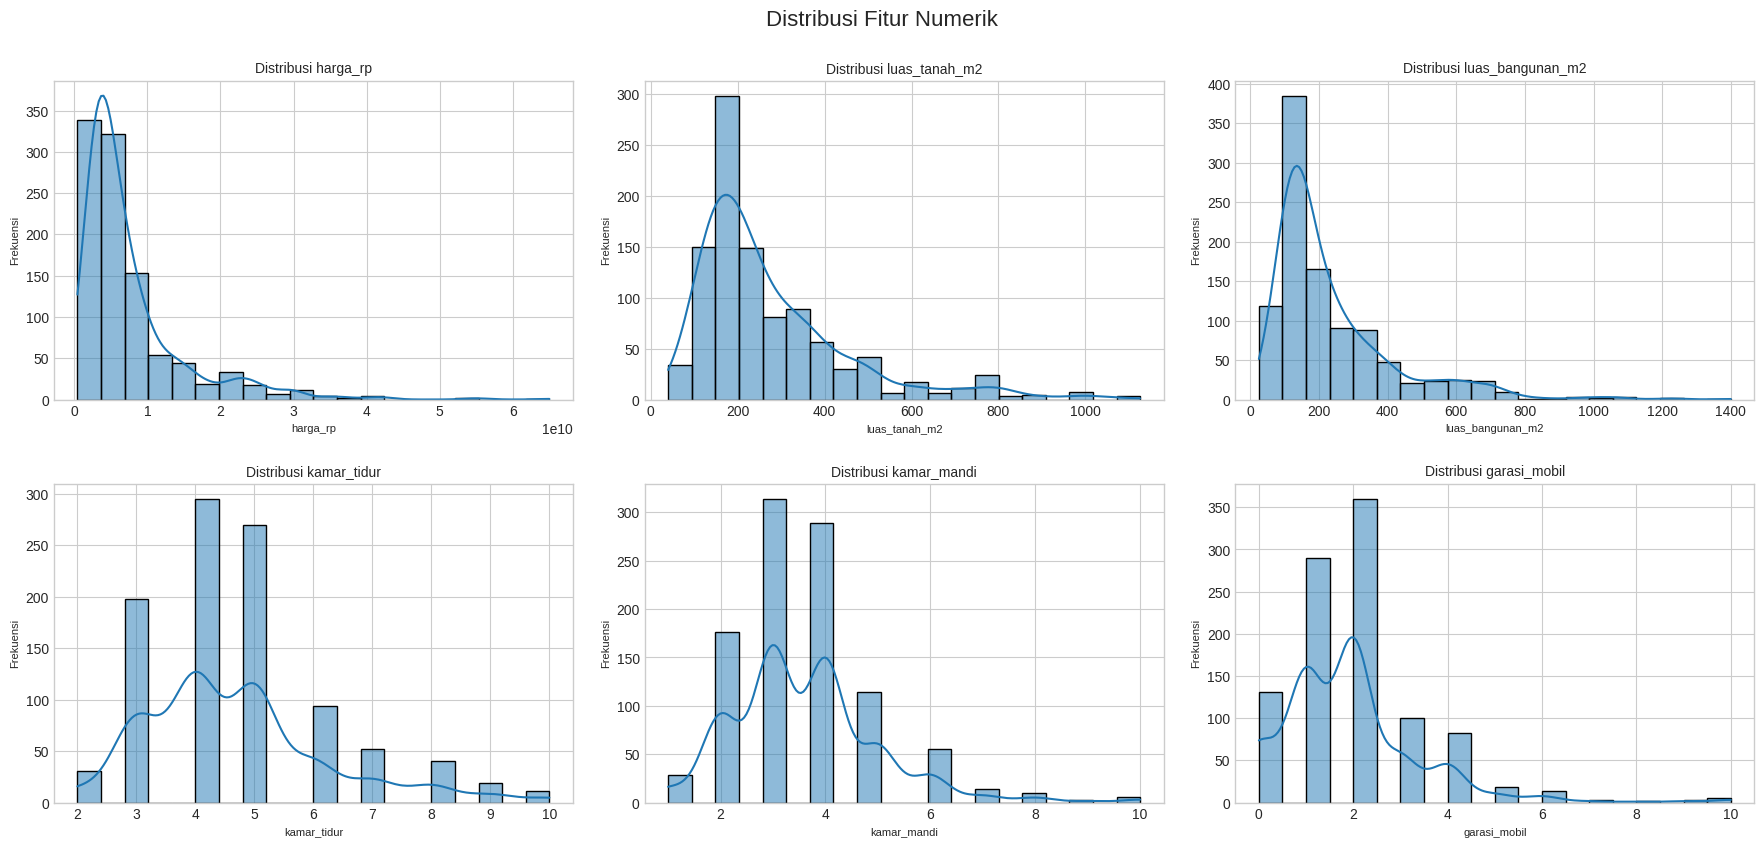

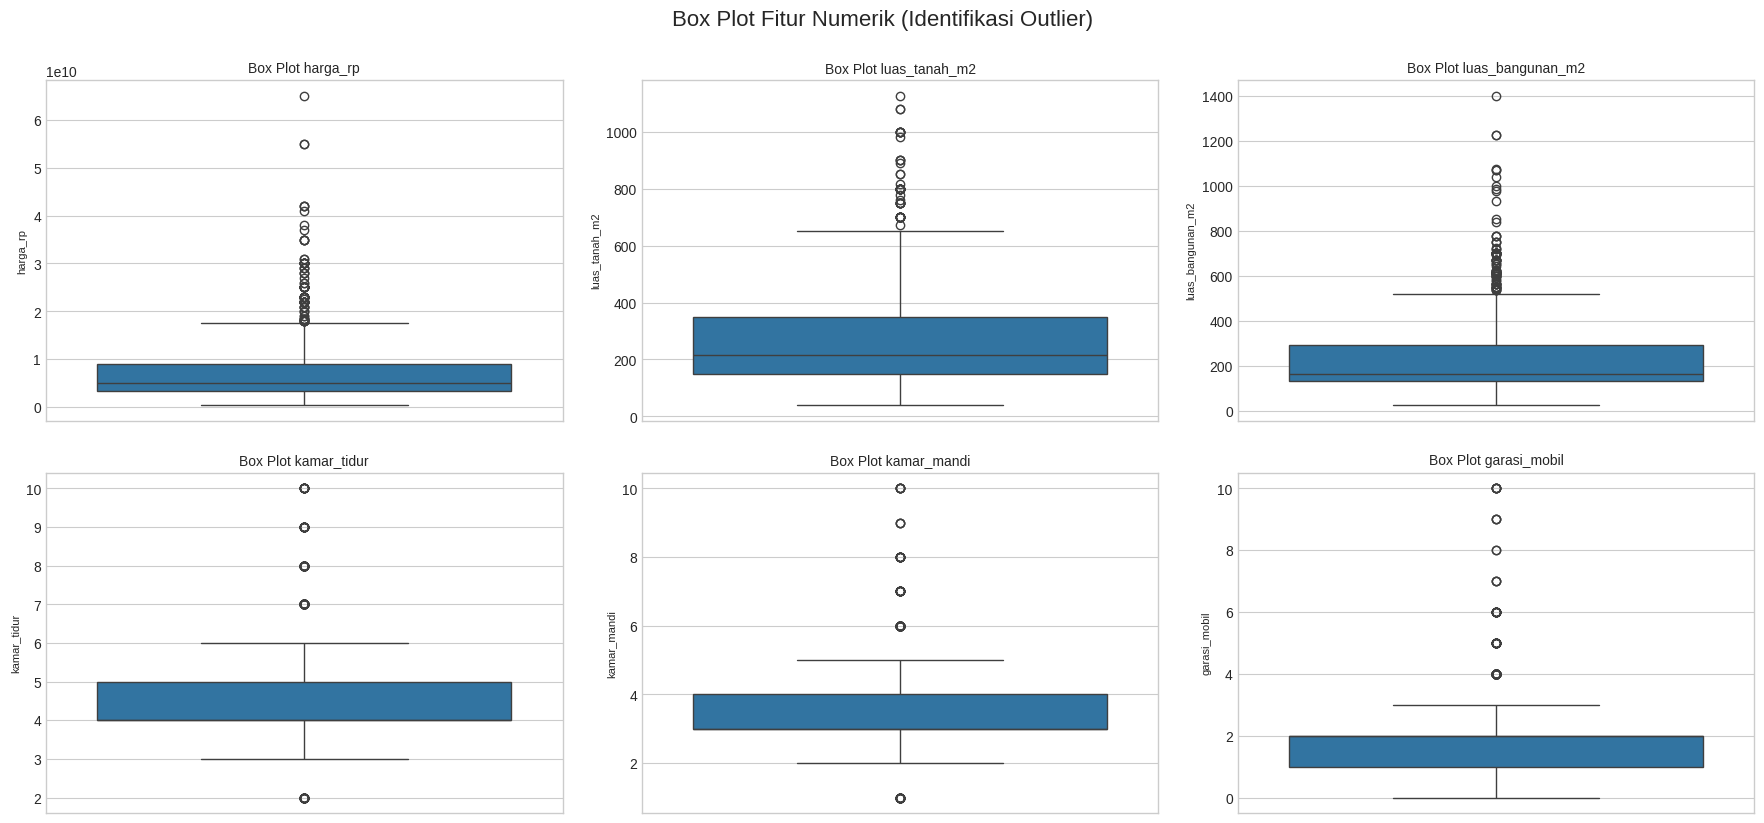

In [4]:
print("\nStatistik Deskriptif Data Bersih:")
print(df.describe())

# Visualisasi Distribusi Fitur Numerik
numerical_features = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1) # Sesuaikan grid jika jumlah fitur berubah
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribusi {col}', fontsize=10)
    plt.xlabel(col, fontsize=8)
    plt.ylabel('Frekuensi', fontsize=8)
plt.tight_layout(pad=2.0)
plt.suptitle('Distribusi Fitur Numerik', fontsize=16, y=1.02)
plt.show()

# Visualisasi Box Plot untuk melihat outlier
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot {col}', fontsize=10)
    plt.ylabel(col, fontsize=8)
plt.tight_layout(pad=2.0)
plt.suptitle('Box Plot Fitur Numerik (Identifikasi Outlier)', fontsize=16, y=1.02)
plt.show()

4. Feature Engineering

In [5]:
# Mengubah harga menjadi satuan juta Rupiah (target variable)
df['harga_juta'] = df['harga_rp'] / 1000000
df = df.drop('harga_rp', axis=1) # Menghapus kolom harga asli

# Membuat fitur kategori berdasarkan kuantil luas tanah
q_luas_tanah = df['luas_tanah_m2'].quantile([0.25, 0.5, 0.75])

def kategorisasi_luas(area, quantiles):
    if area <= quantiles[0.25]:
        return 0 # 'kurang luas'
    elif area <= quantiles[0.50]:
        return 1 # 'sedang'
    else: # area > quantiles[0.50] (karena quantile 0.75 tidak digunakan sebagai batas atas 'sedang')
        return 2 # 'luas'

df['kategori_luas_tanah'] = df['luas_tanah_m2'].apply(lambda x: kategorisasi_luas(x, q_luas_tanah))

# Contoh fitur rasio (opsional, bisa dieksplorasi lebih lanjut)
# df['rasio_bangunan_tanah'] = df['luas_bangunan_m2'] / (df['luas_tanah_m2'] + 1e-6) # +1e-6 untuk menghindari pembagian dengan nol

print("\nData setelah Feature Engineering (5 baris pertama):")
print(df.head())
df.info()


Data setelah Feature Engineering (5 baris pertama):
   luas_tanah_m2  luas_bangunan_m2  kamar_tidur  kamar_mandi  garasi_mobil  harga_juta  kategori_luas_tanah
0            220               220            3            3             0      3800.0                    2
1            180               137            4            3             2      4600.0                    1
2            267               250            4            4             4      3000.0                    2
3             40                25            2            2             0       430.0                    0
4            400               355            6            5             3      9000.0                    2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   luas_tanah_m2        1010 non-null   int64  
 1   luas_bangunan_m2     1010 non-null   i

5. Seleksi Fitur dan Analisis Korelasi

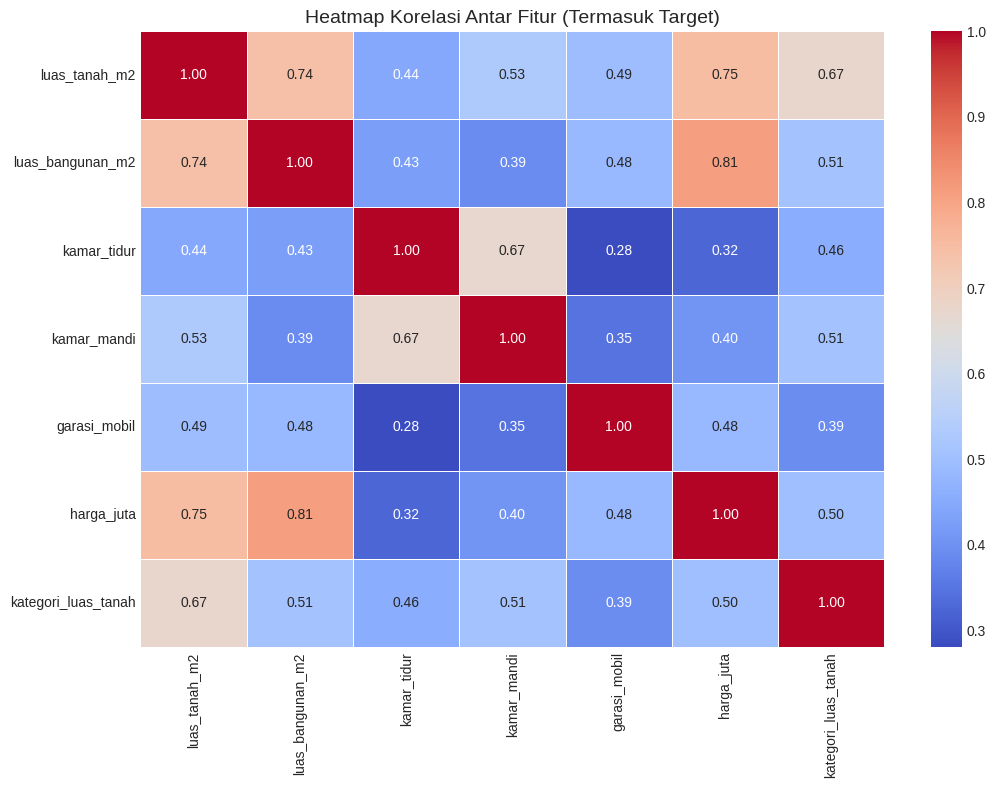


Fitur yang Digunakan (X):
['luas_tanah_m2', 'luas_bangunan_m2', 'kamar_tidur', 'kamar_mandi', 'garasi_mobil', 'kategori_luas_tanah']

Target (y):
harga_juta


In [6]:
# Heatmap Korelasi (termasuk target)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Korelasi Antar Fitur (Termasuk Target)', fontsize=14)
plt.show()

# Memisahkan Fitur (X) dan Target (y)
X = df.drop('harga_juta', axis=1)
y = df['harga_juta']

print("\nFitur yang Digunakan (X):")
print(X.columns.tolist())
print("\nTarget (y):")
print(y.name)

6. Penskalaan Fitur Numerik

In [7]:
# Kolom 'kategori_luas_tanah' sudah berupa ordinal (0, 1, 2), bisa di-scale atau tidak.
# Untuk konsistensi dengan fitur numerik lain, kita akan scale.
numerical_cols_to_scale = X.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X[numerical_cols_to_scale] = scaler.fit_transform(X[numerical_cols_to_scale])

print("\nData Fitur (X) setelah scaling (5 baris pertama):")
print(X.head())


Data Fitur (X) setelah scaling (5 baris pertama):
   luas_tanah_m2  luas_bangunan_m2  kamar_tidur  kamar_mandi  garasi_mobil  kategori_luas_tanah
0      -0.318038         -0.096919    -1.061272    -0.428305     -1.271837             0.905083
1      -0.543039         -0.558367    -0.425139    -0.428305      0.052447            -0.297725
2      -0.053661          0.069870    -0.425139     0.276236      1.376731             0.905083
3      -1.330545         -1.181044    -1.697406    -1.132847     -1.271837            -1.500532
4       0.694470          0.653629     0.847128     0.980778      0.714589             0.905083


7. Pembagian Data (Train & Test)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nUkuran x_train: {x_train.shape}, x_test: {x_test.shape}")
print(f"Ukuran y_train: {y_train.shape}, y_test: {y_test.shape}")


Ukuran x_train: (808, 6), x_test: (202, 6)
Ukuran y_train: (808,), y_test: (202,)


8. Pemodelan dengan XGBRegressor dan Penyetelan Hiperparameter

In [9]:
print("\nMemulai Penyetelan Hiperparameter XGBoost dengan GridSearchCV...")

# Definisikan model XGBoost
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror', early_stopping_rounds=10)

# Definisikan grid parameter untuk GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],       # Jumlah pohon
    'learning_rate': [0.01, 0.05, 0.1],   # Laju pembelajaran
    'max_depth': [3, 5, 7],               # Kedalaman maksimum pohon
    'colsample_bytree': [0.7, 0.8, 1.0],  # Persentase fitur yang digunakan per pohon
    'subsample': [0.7, 0.8, 1.0],         # Persentase sampel yang digunakan per pohon
}

# Pisahkan sebagian data training untuk validasi pada early stopping di GridSearchCV
x_train_for_grid, x_val_for_grid, y_train_for_grid, y_val_for_grid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(x_train_for_grid, y_train_for_grid,
                eval_set=[(x_val_for_grid, y_val_for_grid)])

print(f"\nParameter Terbaik Ditemukan: {grid_search.best_params_}")
print(f"Skor CV (Negative MSE) Terbaik: {grid_search.best_score_:.4f}")

best_xgboost_model = grid_search.best_estimator_


Memulai Penyetelan Hiperparameter XGBoost dengan GridSearchCV...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-rmse:7025.23249
[1]	validation_0-rmse:6842.43220
[2]	validation_0-rmse:6621.89257
[3]	validation_0-rmse:6466.82803
[4]	validation_0-rmse:6305.57456
[5]	validation_0-rmse:6112.08370
[6]	validation_0-rmse:5928.04188
[7]	validation_0-rmse:5800.02849
[8]	validation_0-rmse:5685.13879
[9]	validation_0-rmse:5513.66961
[10]	validation_0-rmse:5371.17349
[11]	validation_0-rmse:5247.81382
[12]	validation_0-rmse:5125.64786
[13]	validation_0-rmse:5037.31645
[14]	validation_0-rmse:4950.07560
[15]	validation_0-rmse:4878.37944
[16]	validation_0-rmse:4808.57753
[17]	validation_0-rmse:4745.10266
[18]	validation_0-rmse:4687.31559
[19]	validation_0-rmse:4601.74076
[20]	validation_0-rmse:4512.77611
[21]	validation_0-rmse:4438.11274
[22]	validation_0-rmse:4368.69304
[23]	validation_0-rmse:4327.00274
[24]	validation_0-rmse:4259.54749
[25]	validation_0-rmse:4201.434

9. Evaluasi Model Terbaik

In [10]:
# Fungsi untuk evaluasi model
def evaluate_model(model, x_data, y_data, dataset_name=""):
    y_pred = model.predict(x_data)
    r2 = r2_score(y_data, y_pred)
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    rmse = np.sqrt(mse)
    print(f"Evaluasi pada {dataset_name}:")
    print(f'  R2 Score: {r2:.4f}')
    print(f'  MAE: {mae:.4f} (juta Rp)')
    print(f'  MSE: {mse:.4f}')
    print(f'  RMSE: {rmse:.4f} (juta Rp)')
    return y_pred

# Evaluasi pada data training
print("\n--- Evaluasi Model pada Data Training ---")
y_pred_train = evaluate_model(best_xgboost_model, x_train, y_train, "Training Set")

# Evaluasi pada data testing
print("\n--- Evaluasi Model pada Data Testing ---")
y_pred_test = evaluate_model(best_xgboost_model, x_test, y_test, "Testing Set")


--- Evaluasi Model pada Data Training ---
Evaluasi pada Training Set:
  R2 Score: 0.9492
  MAE: 858.7464 (juta Rp)
  MSE: 2825151.1453
  RMSE: 1680.8186 (juta Rp)

--- Evaluasi Model pada Data Testing ---
Evaluasi pada Testing Set:
  R2 Score: 0.7612
  MAE: 1921.5205 (juta Rp)
  MSE: 11148025.6712
  RMSE: 3338.8659 (juta Rp)


10. Visualisasi Hasil Prediksi

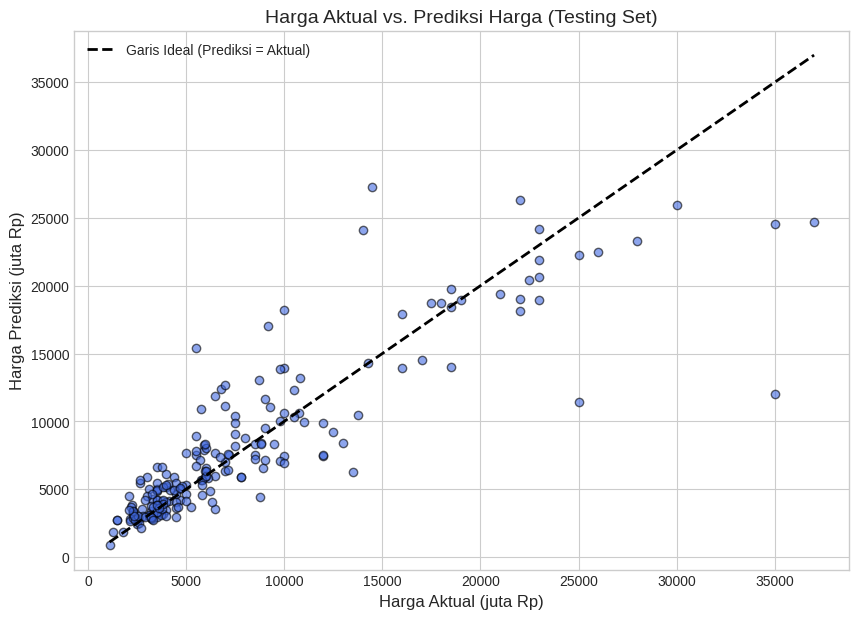

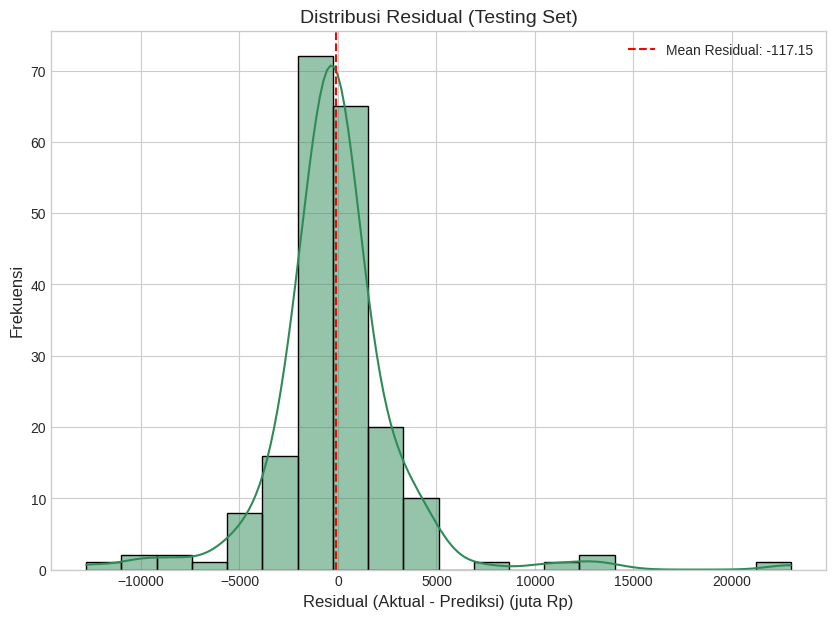

In [11]:
# Plot Prediksi vs Aktual untuk Testing Set
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k', c='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Garis Ideal (Prediksi = Aktual)')
plt.xlabel('Harga Aktual (juta Rp)', fontsize=12)
plt.ylabel('Harga Prediksi (juta Rp)', fontsize=12)
plt.title('Harga Aktual vs. Prediksi Harga (Testing Set)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot Residual
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 7))
sns.histplot(residuals, kde=True, bins=20, color='seagreen')
plt.axvline(residuals.mean(), color='r', linestyle='dashed', linewidth=1.5, label=f'Mean Residual: {residuals.mean():.2f}')
plt.xlabel('Residual (Aktual - Prediksi) (juta Rp)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.title('Distribusi Residual (Testing Set)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

11. Pentingnya Fitur (Feature Importance)

<ipython-input-12-af0d2e8d66ab>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pentingnya', y='Fitur', data=feature_importance_df, palette='viridis')


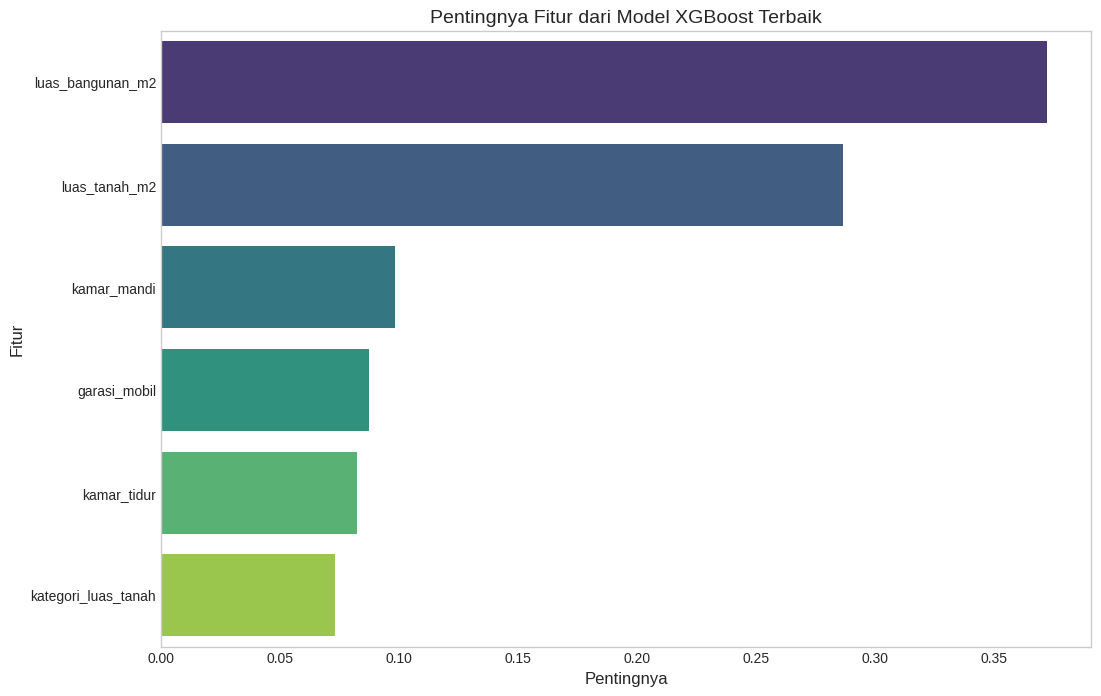


Pentingnya Fitur (dari yang paling penting):
                 Fitur  Pentingnya
1     luas_bangunan_m2    0.372223
0        luas_tanah_m2    0.286692
3          kamar_mandi    0.098140
4         garasi_mobil    0.087537
2          kamar_tidur    0.082374
5  kategori_luas_tanah    0.073033


In [12]:
if hasattr(best_xgboost_model, 'feature_importances_'):
    importances = best_xgboost_model.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Fitur': feature_names, 'Pentingnya': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Pentingnya', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Pentingnya', y='Fitur', data=feature_importance_df, palette='viridis')
    plt.title('Pentingnya Fitur dari Model XGBoost Terbaik', fontsize=14)
    plt.xlabel('Pentingnya', fontsize=12)
    plt.ylabel('Fitur', fontsize=12)
    plt.grid(axis='x')
    plt.show()

    print("\nPentingnya Fitur (dari yang paling penting):")
    print(feature_importance_df)
else:
    print("\nModel terbaik tidak memiliki atribut 'feature_importances_'.")

12. DataFrame Prediksi Final

In [13]:
prediksi_final_df = pd.DataFrame({
    'harga_aktual_juta': y_test.values,
    'harga_prediksi_juta': y_pred_test
})
prediksi_final_df['selisih_juta'] = prediksi_final_df['harga_aktual_juta'] - prediksi_final_df['harga_prediksi_juta']
prediksi_final_df['persentase_error'] = (np.abs(prediksi_final_df['selisih_juta']) / prediksi_final_df['harga_aktual_juta']) * 100

print("\nContoh Hasil Prediksi pada Data Test (dengan selisih dan % error):")
print(prediksi_final_df.head(10))

print("\nStatistik Deskriptif Persentase Error:")
print(prediksi_final_df['persentase_error'].describe())

print("\n--- Proses Selesai ---")


Contoh Hasil Prediksi pada Data Test (dengan selisih dan % error):
   harga_aktual_juta  harga_prediksi_juta  selisih_juta  persentase_error
0             8900.0          6574.722656   2325.277344         26.126712
1             6500.0          3540.587646   2959.412354         45.529421
2             6500.0         11873.118164  -5373.118164         82.663356
3            37000.0         24670.878906  12329.121094         33.321949
4            18500.0         19731.343750  -1231.343750          6.655912
5             8500.0          8324.935547    175.064453          2.059582
6             2150.0          2769.988281   -619.988281         28.836664
7             2250.0          3839.222412  -1589.222412         70.632107
8             4000.0          3497.738770    502.261230         12.556531
9             3799.0          4121.686523   -322.686523          8.493986

Statistik Deskriptif Persentase Error:
count    202.000000
mean      26.801405
std       27.029579
min        0.01577